Here are some simple codes that I created in grad school in matlab. Eventually, I would like to convert these to python, but they work fine in octave!

In [13]:
%load_ext oct2py.ipython

The oct2py.ipython extension is already loaded. To reload it, use:
  %reload_ext oct2py.ipython


In [14]:
%%octave
% Gauss elimination function solves a system of linear equations
% the form of Ax = B is required, such that A is a square matrix of nxn and
% B is a matrix of nx1.
a = [4 1 6 ; 3 3 1 ; 6 9 1]
b=[22;5;3]

ab = [a,b]
[R,C] = size(ab);
for j=1:R-1
    for i = j+1:R
        ab(i,j:C)=ab(i,j:C)-ab(i,j)/ab(j,j)*ab(j,j:C);
    end
end
x = zeros(R,1);
x(R) = ab(R,C)/ab(R,R);
for i=R - 1:-1:1
    x(i) = (ab(i,C) - ab(i,i+1:R) * x(i+1:R)) / ab(i,i);
end
x

a =

        4        1        6
        3        3        1
        6        9        1

b =

       22
        5
        3

ab =

        4        1        6       22
        3        3        1        5
        6        9        1        3

x =

  2.48485
  -1.57576
  2.27273

ans =  1

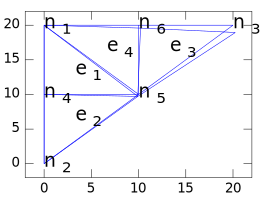

In [15]:
%%octave
% ME 609 FEA program
% hmk 2
% Gusset plate problem using 4 CST elemetnts. Uniform load across top edge
% is modeled with 2 concentrated forces
%% Clear workspace
clc
clear all
gcf
clf reset
%% define variables
E      = 10e6;    % modulus of elasticity
plotfactor = 1e2;  % displacement factor for plot
poisson     = 0.3;    % poisson ratio
%% Set nodal coordinates and element destination entries. 
%         x1   y1   x2  y2  x3  y3  x4  y4  x5  y5   x6  y6
nodexy = [0 20 0 0 20 20 0 10 10 10 10 20];  % global node coordinets (arbitrary)    
%         u1   u2   u3  u4  u5  u6  u7  u8  u9  u10  u11  u12
nodeBC = [1 1 1 1 0 0 1 1 0 0 0 0];  % is dof fixed?
%          x  y  x  y  x  y
%          u1 u2 u# u# u# u#            
elnodes = [9 10 1 2 7 8;
           9 10 7 8 3 4;
           9 10 5 6 11 12;
           9 10 11 12 1 2];  
elements     = length(elnodes(:,1));      % Number of elements
nodes        = length(nodexy)/2;      % number of nodes
realdof      = length(nodeBC)-sum(nodeBC);      % number of non-trivial/moving degrees of freedom
doftotal     = nodes*2;      % number of total degrees of freedom
nodexyplot   = zeros(nodes,2);  % global coordinates of nodes for plotting
nodeplotload = zeros(nodes,2); % global coordiantes for deflected nodes for plotting 
P       = zeros(doftotal,1);       % total load vector
U       = zeros(doftotal,1);    % displacements 
Ue      = zeros(6,1);           % displacements per element, 6 for CST
Ke      = zeros(6,6);           % stiffness per element
K       = zeros(doftotal,doftotal);   %  totral structure stiffness
B       = zeros(3,6);           % dN/dx , strain = B*u, correct for CST
D       = zeros(3,3);           % Elasticity Matrix (D), correct for CST
strain  = zeros(elements,3);       % Element(row) strain per node (column)
stress  = zeros(elements,3);     % Element(row) stress per node (column)
pstress = 1; % pstress >0 plane stress; pstress = 0 plane strain
adj = zeros(nodes,nodes);
conmat = [1 6;
          1 5;
          1 4;
          2 4;
          2 5;
          3 6;
          3 5;
          4 5;
          5 6];
     for i = 1:length(conmat)
         adj(conmat(i,1),conmat(i,2)) = 1;
     end    
%% Load Vector
P(2) = -20000/3; % 
P(12) = -20000/3; % 
P(6) = -20000/3; % 
%% Elasticity Matrix
D(2,1) = poisson;
D(1,2) = poisson;
switch pstress
case pstress == 1
    D(1,1) = 1;
    D(2,2) = 1;
    D(3,3) = 0.5*(1-poisson);
    D = D*E/(1-poisson*poisson);
case pstress == 0
    D(1,1) = 1-poisson;
    D(2,2) = 1-poisson;
    D(3,3) = 0.5*(1-2*poisson);
    D = D*E/((1-2*poisson)*(1+poisson));
end
%% loop over each element, build element [B] matrix then element matrix.
% Assemble element stiffness into structure stiffness by building B matrix
% B = dN/dx
% x,y are the local nodal coordinates
for i = 1:elements % looping through each element and building shape function
   x1 = nodexy(elnodes(i,1));
   x2 = nodexy(elnodes(i,3));
   x3 = nodexy(elnodes(i,5));
   y1 = nodexy(elnodes(i,2));
   y2 = nodexy(elnodes(i,4));
   y3 = nodexy(elnodes(i,6));
   x13 = x1-x3;
   x21 = x2-x1;
   x32 = x3-x2;
   y12 = y1-y2;
   y23 = y2-y3;
   y31 = y3-y1;
   B(1,1) = y23;
   B(3,1) = x32;
   B(2,2) = x32;
   B(3,2) = y23;
   B(1,3) = y31;
   B(3,3) = x13;
   B(2,4) = x13;
   B(3,4) = y31;
   B(1,5) = y12;
   B(3,5) = x21;
   B(2,6) = x21;
   B(3,6) = y12;
   A = 0.5*(x1*y23 + x2*y31 + x3*y12);
   B = B/(2*A);
   Ke = B' * D * B * A;
   % assemble elements into structure stiffness
   for kk= 1:6                    % 6 u dof in CST
    ii = elnodes(i,kk);           % u(j) in element i
       for j = 1:6               % 6 v dof in CST
            jj = elnodes(i,j);   % vj in element i
            K(ii,jj) = K(ii,jj) + Ke(kk,j);   % add element to total structure
       end
   end
end
%% Apply Boundary Conditions via partition matrix method for 0 displacement only
Ksol = K;
Psol = P;
for i = 1:doftotal
    if nodeBC(i) == 1
        Ksol(i,:) = 0;
        Ksol(:,i) = 0;
        Ksol(i,i) = 1;
        Psol(i) = 0;
    end
end
%% Solve displacements
U = Ksol\Psol;
%% retrieve kru of total structure stiffness matrix and get reactions
R = K*U;
%% loop over each element and form [B], get strains then stresses
for i=1:elements
   Ue = zeros(6,1);
   x1 = nodexy(elnodes(i,1));
   x2 = nodexy(elnodes(i,3));
   x3 = nodexy(elnodes(i,5));
   y1 = nodexy(elnodes(i,2));
   y2 = nodexy(elnodes(i,4));
   y3 = nodexy(elnodes(i,6));
   x13 = x1-x3;
   x21 = x2-x1;
   x32 = x3-x2;
   y12 = y1-y2;
   y23 = y2-y3;
   y31 = y3-y1;
   B(1,1) = y23;
   B(3,1) = x32;
   B(2,2) = x32;
   B(3,2) = y23;
   B(1,3) = y31;
   B(3,3) = x13;
   B(2,4) = x13;
   B(3,4) = y31;
   B(1,5) = y12;
   B(3,5) = x21;
   B(2,6) = x21;
   B(3,6) = y12;
   A = 0.5*(x1*y23 + x2*y31 + x3*y12);
   B = B*0.5/A;
   for j = 1:6
       ii = elnodes(i,j);
           Ue(j) = U(ii);
   end
   strain(i,:) = (B*Ue)';
   stress(i,:) = (D*B*Ue)';
end
%% plotting of FEA structure for visual confirmation of results
hold on
% transforms global node coordinates nodexy from 1xc vector to nx2
for i = 1:nodes
    nodexyplot(i,:) = [nodexy(i*2-1) nodexy(i*2)];
end   
gplot(adj,nodexyplot)
nodexyload = nodexy + U'*plotfactor;
for i = 1:nodes
    nodeplotload(i,:) = [nodexyload(i*2-1) nodexyload(i*2)];
end  
gplot(adj,nodeplotload,'--')
[r c] = size(nodexyplot);
for i = 1:r
    text(nodexyplot(i,1), nodexyplot(i,2), cat(2,'n_',num2str(i)),'Fontsize',14)
end
[r c] = size(elnodes) ;
for i = 1:r
    x = (nodexy(elnodes(i,1))+ nodexy(elnodes(i,3))+ nodexy(elnodes(i,5)))/3;
    y = (nodexy(elnodes(i,2))+ nodexy(elnodes(i,4))+ nodexy(elnodes(i,6)))/3;
    text(x,y, cat(2,'e_',num2str(i)),'Fontsize',14)
end
hold off
xlim ( [min(nodexyplot(:,1))-2 max(nodexyplot(:,1))+2 ])
ylim ( [min(nodexyplot(:,2))-2 max(nodexyplot(:,2))+2 ])

ans =  1
Done

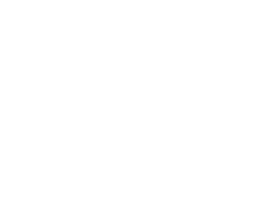

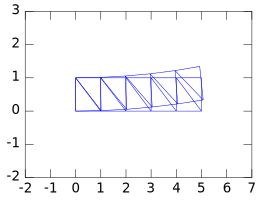

In [16]:
%%octave
% ME 609 FEA program
% hmk 2
% Gusset plate problem using 4 CST elemetnts. Uniform load across top edge
% is modeled with 2 concentrated forces
%% Clear workspace
clc
clear all
gcf
clf reset
%% define variables
E      = 10e6;    % modulus of elasticity
L      = 20;     % length of sketch (see drawing)
Q      = 1000;    % pounds/inch load 
plotfactor = 1e2;  % displacement factor for plot
poisson     = 0.3;    % poisson ratio
%% Set nodal coordinates and element destination entries. 
%         x1   y1   x2  y2  x3  y3  x4  y4  x5  y5   x6  y6
nodexy = [0
          0
          1
          0
          2
          0
          3
          0
          4
          0
          5
          0
          5
          1
          4
          1
          3
          1
          2
          1
          1
          1
          0
          1]';  % global node coordinets (arbitrary)    
%         u1   u2   u3  u4  u5  u6  u7  u8  u9  u10  u11  u12
nodeBC = [1
          1
          0
          0
          0
          0
          0
          0
          0
          0
          0
          0
          0
          0
          0
          0
          0
          0
          0
          0
          0
          0
          1
          1]';  % is dof fixed?
%          x  y  x  y  x  y
%          u1 u2 u# u# u# u#            
elnodes = [1 2 3 4 23 24; %e1
           3 4 5 6 21 22; %e2
           5 6 7 8 19 20; %e3
           7 8 9 10 17 18; %e4
           9 10 11 12 15 16; %e5
           11 12 13 14 15 16; %e6
           9 10 15 16 17 18;%e7
           7 8 17 18 19 20; %e8
           5 6 19 20 21 22;
           3 4 21 22 23 24];  
elements     = length(elnodes(:,1));      % Number of elements
nodes        = length(nodexy)/2;      % number of nodes
realdof      = length(nodeBC)-sum(nodeBC);      % number of non-trivial/moving degrees of freedom
doftotal     = nodes*2;      % number of total degrees of freedom
nodexyplot   = zeros(nodes,2);  % global coordinates of nodes for plotting
nodeplotload = zeros(nodes,2); % global coordiantes for deflected nodes for plotting 
P       = zeros(doftotal,1);       % total load vector
U       = zeros(doftotal,1);    % displacements 
Ue      = zeros(6,1);           % displacements per element, 6 for CST
Ke      = zeros(6,6);           % stiffness per element
K       = zeros(doftotal,doftotal);   %  totral structure stiffness
B       = zeros(3,6);           % dN/dx , strain = B*u, correct for CST
D       = zeros(3,3);           % Elasticity Matrix (D), correct for CST
strain  = zeros(elements,3);       % Element(row) strain per node (column)
stress  = zeros(elements,3);     % Element(row) stress per node (column)
pstress = 1; % pstress >0 plane stress; pstress = 0 plane strain

adj = zeros(nodes,nodes);
conmat = [1 2;
         1 12;
         2 3;
         2 11;
         2 12;
         3 4;
         3 10;
         3 11;
         4 5;
         4 9;
         4 10;
         5 6;
         5 8;
         5 9;
         6 7;
         6 8;
         7 8;
         8 9;
         9 10;
         10 11;
         11 12];
     for i = 1:length(conmat)
         adj(conmat(i,1),conmat(i,2)) = 1;
     end         
%% Load Vector
P(11) = 1000; 
P(13) = -1000;

%% Elasticity Matrix
D(2,1) = poisson;
D(1,2) = poisson;
switch pstress
case pstress == 1
    D(1,1) = 1;
    D(2,2) = 1;
    D(3,3) = 0.5*(1-poisson);
    D = D*E/(1-poisson*poisson);
case pstress == 0
    D(1,1) = 1-poisson;
    D(2,2) = 1-poisson;
    D(3,3) = 0.5*(1-2*poisson);
    D = D*E/((1-2*poisson)*(1+poisson));
end
%% loop over each element, build element [B] matrix then element matrix.
% Assemble element stiffness into structure stiffness by building B matrix
% B = dN/dx
% x,y are the local nodal coordinates
for i = 1:elements % looping through each element and building shape function
   x1 = nodexy(elnodes(i,1));
   x2 = nodexy(elnodes(i,3));
   x3 = nodexy(elnodes(i,5));
   y1 = nodexy(elnodes(i,2));
   y2 = nodexy(elnodes(i,4));
   y3 = nodexy(elnodes(i,6));
   x13 = x1-x3;
   x21 = x2-x1;
   x32 = x3-x2;
   y12 = y1-y2;
   y23 = y2-y3;
   y31 = y3-y1;
   B(1,1) = y23;
   B(3,1) = x32;
   B(2,2) = x32;
   B(3,2) = y23;
   B(1,3) = y31;
   B(3,3) = x13;
   B(2,4) = x13;
   B(3,4) = y31;
   B(1,5) = y12;
   B(3,5) = x21;
   B(2,6) = x21;
   B(3,6) = y12;
   A = 0.5*(x1*y23 + x2*y31 + x3*y12);
   B = B/(2*A);
   Ke = B' * D * B * A;
   % assemble elements into structure stiffness
   for kk= 1:6                    % 6 u dof in CST
    ii = elnodes(i,kk);           % u(j) in element i
       for j = 1:6               % 6 v dof in CST
            jj = elnodes(i,j);   % vj in element i
            K(ii,jj) = K(ii,jj) + Ke(kk,j);   % add element to total structure
       end
   end
end
%% Apply Boundary Conditions via partition matrix method for 0 displacement only
Ksol = K;
Psol = P;
for i = 1:doftotal
    if nodeBC(i) == 1
        Ksol(i,:) = 0;
        Ksol(:,i) = 0;
        Ksol(i,i) = 1;
        Psol(i) = 0;
    end
end
%% Solve displacements
U = Ksol\Psol;
%% retrieve kru of total structure stiffness matrix and get reactions
R = K*U;
%% loop over each element and form [B], get strains then stresses
for i=1:elements
   Ue = zeros(6,1);
   x1 = nodexy(elnodes(i,1));
   x2 = nodexy(elnodes(i,3));
   x3 = nodexy(elnodes(i,5));
   y1 = nodexy(elnodes(i,2));
   y2 = nodexy(elnodes(i,4));
   y3 = nodexy(elnodes(i,6));
   x13 = x1-x3;
   x21 = x2-x1;
   x32 = x3-x2;
   y12 = y1-y2;
   y23 = y2-y3;
   y31 = y3-y1;
   B(1,1) = y23;
   B(3,1) = x32;
   B(2,2) = x32;
   B(3,2) = y23;
   B(1,3) = y31;
   B(3,3) = x13;
   B(2,4) = x13;
   B(3,4) = y31;
   B(1,5) = y12;
   B(3,5) = x21;
   B(2,6) = x21;
   B(3,6) = y12;
   A = 0.5*(x1*y23 + x2*y31 + x3*y12);
   B = B*0.5/A;
   for j = 1:6
       ii = elnodes(i,j);
           Ue(j) = U(ii);
   end
   strain(i,:) = (B*Ue)';
   stress(i,:) = (D*B*Ue)';
end
%% plotting of FEA structure for visual confirmation of results
figure ('Name','Plot of FEA structure')
% transforms global node coordinates nodexy from 1xc vector to nx2
for i = 1:nodes
    nodexyplot(i,:) = [nodexy(i*2-1) nodexy(i*2)];
end   
gplot(adj,nodexyplot)
hold on
nodexyload = nodexy + U'*plotfactor;
for i = 1:nodes
    nodeplotload(i,:) = [nodexyload(i*2-1) nodexyload(i*2)];
end  
gplot(adj,nodeplotload,'--')
hold off
xlim ( [min(nodexyplot(:,1))-2 max(nodexyplot(:,1))+2 ])
ylim ( [min(nodexyplot(:,2))-2 max(nodexyplot(:,2))+2 ])
disp('Done')

ans =  1
Ke =

  1.0e+006 *

  1.92308  0.00000  0.00000  -1.92308  -1.92308  1.92308
  0.00000  5.49451  -1.64835  0.00000  1.64835  -5.49451
  0.00000  -1.64835  5.49451  0.00000  -5.49451  1.64835
  -1.92308  0.00000  0.00000  1.92308  1.92308  -1.92308
  -1.92308  1.64835  -5.49451  1.92308  7.41758  -3.57143
  1.92308  -5.49451  1.64835  -1.92308  -3.57143  7.41758

Ke =

  1.0e+006 *

  1.92308  0.00000  -1.92308  -1.92308  0.00000  1.92308
  0.00000  5.49451  -1.64835  -5.49451  1.64835  0.00000
  -1.92308  -1.64835  7.41758  3.57143  -5.49451  -1.92308
  -1.92308  -5.49451  3.57143  7.41758  -1.64835  -1.92308
  0.00000  1.64835  -5.49451  -1.64835  5.49451  0.00000
  1.92308  0.00000  -1.92308  -1.92308  0.00000  1.92308

Ke =

  1.0e+006 *

  5.49451  0.00000  0.00000  1.64835  -5.49451  -1.64835
  0.00000  1.92308  1.92308  0.00000  -1.92308  -1.92308
  0.00000  1.92308  1.92308  0.00000  -1.92308  -1.92308
  1.64835  0.00000  0.00000  5.49451  -1.64835  -5.49451
  -5.49451 

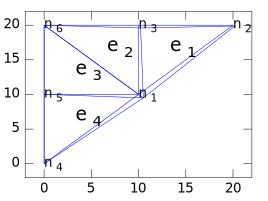

In [17]:
%%octave
% ME 609 FEA program
% hmk 2
% Gusset plate problem using 4 CST elemetnts. Uniform load across top edge
% is modeled with 2 concentrated forces
%% Clear workspace
clc
clear all
gcf
clf reset
%% define variables
E      = 10e6;    % modulus of elasticity
plotfactor = 1e2;  % displacement factor for plot
poisson     = 0.3;    % poisson ratio
%% Set nodal coordinates and element destination entries.
% Node definitions must represent a Rigid body 
%         x1   y1   x2  y2  x3  y3  x4  y4  x5  y5   x6  y6
nodexy = [10  10   20  20   10 20  0   0   0    10  0   20];  % global node coordinets (arbitrary)    

% Boundary conditions must prevent rigid body motion by constraining all
% dofs
%         u1   u2   u3  u4  u5  u6  u7  u8  u9  u10  u11  u12
nodeBC = [1         1       0   0   0   0   1   1   1   1    1   1;  % is dof a Boundary condition
          0.005    -.005    0   0   0   0   0   0   0   0    0   0]; % the amount of dispacement
%          x  y  x  y  x  y
%          u1 u2 u# u# u# u#            
elnodes = [1  2  3  4  5  6;   % 1 element per row, dofs labled CCW (arbitrary)
           1  2  5  6  11 12;
           1  2  11 12 9  10;
           1  2  9  10 7  8];  
%      1 2 3 4 5 6
adj = [0 1 1 1 1 1; %1
       0 0 1 0 0 0; %2
       0 0 0 0 0 1; %3
       0 0 0 0 1 0; %4
       0 0 0 0 0 1; %5
       0 0 0 0 0 0];%6 % adjecency matrix what nodes are connected to what       
elements     = length(elnodes(:,1));      % Number of elements
nodes        = length(nodexy)/2;      % number of nodes
doftotal     = nodes*2;      % number of total degrees of freedom
nodexyplot   = zeros(nodes,2);  % global coordinates of nodes for plotting
nodeplotload = zeros(nodes,2); % global coordiantes for deflected nodes for plotting 
P       = zeros(doftotal,1);       % total load vector
U       = zeros(doftotal,1);    % displacements 
Ue      = zeros(6,1);           % displacements per element, 6 for CST
Ke      = zeros(6,6);           % stiffness per element
K       = zeros(doftotal,doftotal);   %  totral structure stiffness
B       = zeros(3,6);           % dN/dx , strain = B*u, correct for CST
D       = zeros(3,3);           % Elasticity Matrix (D), correct for CST
strain  = zeros(elements,3);       % Element(row) strain per node (column)
stress  = zeros(elements,3);     % Element(row) stress per node (column)
pstress = 1; % pstress >0 plane stress; pstress = 0 plane strain
%% Load Vector
% P(4) = -20000/3; % 
% P(6) = -20000/3; % 10 
% P(12) = -20000/3; % 10 
%% Elasticity Matrix
D(2,1) = poisson;
D(1,2) = poisson;
switch pstress
case pstress == 1
    D(1,1) = 1;
    D(2,2) = 1;
    D(3,3) = 0.5*(1-poisson);
    D = D*E/(1-poisson*poisson);
case pstress == 0
    D(1,1) = 1-poisson;
    D(2,2) = 1-poisson;
    D(3,3) = 0.5*(1-2*poisson);
    D = D*E/((1-2*poisson)*(1+poisson));
end
%% loop over each element, build element [B] matrix then element matrix.
% Assemble element stiffness into structure stiffness by building B matrix
% B = dN/dx
% x,y are the local nodal coordinates
for i = 1:elements % looping through each element and building shape function
   x1 = nodexy(elnodes(i,1));
   x2 = nodexy(elnodes(i,3));
   x3 = nodexy(elnodes(i,5));
   y1 = nodexy(elnodes(i,2));
   y2 = nodexy(elnodes(i,4));
   y3 = nodexy(elnodes(i,6));
   x13 = x1-x3;
   x21 = x2-x1;
   x32 = x3-x2;
   y12 = y1-y2;
   y23 = y2-y3;
   y31 = y3-y1;
   B(1,1) = y23;
   B(3,1) = x32;
   B(2,2) = x32;
   B(3,2) = y23;
   B(1,3) = y31;
   B(3,3) = x13;
   B(2,4) = x13;
   B(3,4) = y31;
   B(1,5) = y12;
   B(3,5) = x21;
   B(2,6) = x21;
   B(3,6) = y12;
   A = 0.5*(x1*y23 + x2*y31 + x3*y12);
   B = B/(2*A);
   Ke = B' * D * B * A
   % assemble elements into structure stiffness
   for kk= 1:6                    % 6 u dof in CST
    ii = elnodes(i,kk);           % u(j) in element i
       for j = 1:6               % 6 v dof in CST
            jj = elnodes(i,j);   % vj in element i
            K(ii,jj) = K(ii,jj) + Ke(kk,j);   % add element to total structure
       end
   end
end
%% Apply Boundary Conditions via partition matrix method
Ksol = K;
Psol = P;

for i = 1:doftotal  % applies BC displacement 
    if nodeBC(1,i) == 1
        for j = 1:doftotal
            Psol(j) = Psol(j) - K(j,i)*nodeBC(2,i);
        end
    end
end      

for i = 1:doftotal
    if nodeBC(1,i) == 1
        Ksol(i,:) = 0;
        Ksol(:,i) = 0;
        Ksol(i,i) = 1;
    end      
end

for i = 1:doftotal
    if nodeBC(1,i) == 1
        Psol(i) = nodeBC(2,i);
    end
end

%% Solve displacements
U = Ksol\Psol;
%% retrieve kru of total structure stiffness matrix and get reactions
R = K*U
R = R-P
%% loop over each element and form [B], get strains then stresses
% Stress: row 1:numelements, column 1,2,3 = {S11, S22, S12}
for i=1:elements
   Ue = zeros(6,1);
   x1 = nodexy(elnodes(i,1));
   x2 = nodexy(elnodes(i,3));
   x3 = nodexy(elnodes(i,5));
   y1 = nodexy(elnodes(i,2));
   y2 = nodexy(elnodes(i,4));
   y3 = nodexy(elnodes(i,6));
   x13 = x1-x3;
   x21 = x2-x1;
   x32 = x3-x2;
   y12 = y1-y2;
   y23 = y2-y3;
   y31 = y3-y1;
   B(1,1) = y23;
   B(3,1) = x32;
   B(2,2) = x32;
   B(3,2) = y23;
   B(1,3) = y31;
   B(3,3) = x13;
   B(2,4) = x13;
   B(3,4) = y31;
   B(1,5) = y12;
   B(3,5) = x21;
   B(2,6) = x21;
   B(3,6) = y12;
   A = 0.5*(x1*y23 + x2*y31 + x3*y12);
   B = B*0.5/A;
   for j = 1:6
       ii = elnodes(i,j);
           Ue(j) = U(ii);
   end
   strain(i,:) = (B*Ue)';
   stress(i,:) = (D*B*Ue)';
end
%% plotting of FEA structure for visual confirmation of results
gcf
% transforms global node coordinates nodexy from 1xc vector to nx2
for i = 1:nodes
    nodexyplot(i,:) = [nodexy(i*2-1) nodexy(i*2)];
end   
gplot(adj,nodexyplot)
hold on
nodexyload = nodexy + U'*plotfactor;
for i = 1:nodes
    nodeplotload(i,:) = [nodexyload(i*2-1) nodexyload(i*2)];
end  
gplot(adj,nodeplotload,'--')
hold off
[r c] = size(nodexyplot);
for i = 1:r
    text(nodexyplot(i,1), nodexyplot(i,2), cat(2,'n_',num2str(i)) )
end
[r c] = size(elnodes) ;
for i = 1:r
    x = (nodexy(elnodes(i,1))+ nodexy(elnodes(i,3))+ nodexy(elnodes(i,5)))/3;
    y = (nodexy(elnodes(i,2))+ nodexy(elnodes(i,4))+ nodexy(elnodes(i,6)))/3;
    text(x,y, cat(2,'e_',num2str(i)),'Fontsize',14)
end
xlim ( [min(nodexyplot(:,1))-2 max(nodexyplot(:,1))+2 ])
ylim ( [min(nodexyplot(:,2))-2 max(nodexyplot(:,2))+2 ])
K
U
P
strain
stress

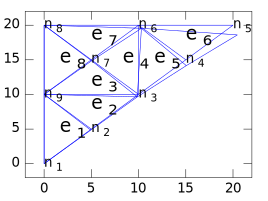

In [18]:
%%octave
% ME 609 FEA program
% hmk 2
% Gusset plate problem using 4 CST elemetnts. Uniform load across top edge
% is modeled with 2 concentrated forces
%% Clear workspace
clc
clear all
clf reset
%% define variables
E      = 10e6;    % modulus of elasticity
L      = 20;     % length of sketch (see drawing)
Q      = 1000;    % pounds/inch load 
plotfactor = 1e2;  % displacement factor for plot
poisson     = 0.3;    % poisson ratio
%% Set nodal coordinates and element destination entries. 
%         x1   y1   x2  y2  x3  y3  x4  y4  x5  y5   x6  y6 x7  y7  x8  y8
nodexy = [0     0   L/4 L/4 L/2  L/2 3*L/4 3*L/4 L L L/2 L L/4 3*L/4 0 L 0 L/2];  % global node coordinets (arbitrary)    
%         u1   u2   u3  u4  u5  u6  u7  u8  u9  u10  u11  u12
nodeBC = [1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1];  % is dof fixed?
%          x  y  x  y  x  y
%          u1 u2 u# u# u# u#            
elnodes = [1 2 3 4 17 18;
           3 4 5 6 17 18;
           5 6 13 14 17 18;
           5 6 11 12 13 14;
           5 6 7 8 11 12;
           7 8 9 10 11 12;
           13 14 11 12 15 16;
           17 18 13 14 15 16];   % 1 element per row, dofs labled CCW (arbitrary)
elements     = length(elnodes(:,1));      % Number of elements
nodes        = length(nodexy)/2;      % number of nodes
doftotal     = nodes*2;      % number of total degrees of freedom
nodexyplot   = zeros(nodes,2);  % global coordinates of nodes for plotting
nodeplotload = zeros(nodes,2); % global coordiantes for deflected nodes for plotting 
P       = zeros(doftotal,1);       % total load vector
U       = zeros(doftotal,1);    % displacements 
Ue      = zeros(6,1);           % displacements per element, 6 for CST
Ke      = zeros(6,6);           % stiffness per element
K       = zeros(doftotal,doftotal);   %  totral structure stiffness
B       = zeros(3,6);           % dN/dx , strain = B*u, correct for CST
D       = zeros(3,3);           % Elasticity Matrix (D), correct for CST
strain  = zeros(elements,3);       % Element(row) strain per node (column)
stress  = zeros(elements,3);     % Element(row) stress per node (column)
pstress = 1; % pstress >0 plane stress; pstress = 0 plane strain
adj = zeros(nodes,nodes);
adj(1,2) = 1;
adj(1,9) = 1;
adj(2,3) = 1;
adj(2,9) = 1;
adj(3,4) = 1;
adj(3,6) = 1;
adj(3,7) = 1;
adj(3,9) = 1;
adj(4,5) = 1;
adj(4,6) = 1;
adj(5,6) = 1;
adj(6,8) = 1;
adj(6,7) = 1;
adj(7,8) = 1;
adj(7,9) = 1;
adj(8,9) = 1;
%% Load Vector
P(10) = -20000/3; % 10 kips load
P(12) = -20000/3; % 10 kips load
P(16) = -20000/3; % 10 kips load
%% Elasticity Matrix
D(2,1) = poisson;
D(1,2) = poisson;
switch pstress
case pstress == 1
    D(1,1) = 1;
    D(2,2) = 1;
    D(3,3) = 0.5*(1-poisson);
    D = D*E/(1-poisson*poisson);
case pstress == 0
    D(1,1) = 1-poisson;
    D(2,2) = 1-poisson;
    D(3,3) = 0.5*(1-2*poisson);
    D = D*E/((1-2*poisson)*(1+poisson));
end
%% loop over each element, build element [B] matrix then element matrix.
% Assemble element stiffness into structure stiffness by building B matrix
% B = dN/dx
% x,y are the local nodal coordinates
for i = 1:elements % looping through each element and building shape function
   x1 = nodexy(elnodes(i,1));
   x2 = nodexy(elnodes(i,3));
   x3 = nodexy(elnodes(i,5));
   y1 = nodexy(elnodes(i,2));
   y2 = nodexy(elnodes(i,4));
   y3 = nodexy(elnodes(i,6));
   x13 = x1-x3;
   x21 = x2-x1;
   x32 = x3-x2;
   y12 = y1-y2;
   y23 = y2-y3;
   y31 = y3-y1;
   B(1,1) = y23;
   B(3,1) = x32;
   B(2,2) = x32;
   B(3,2) = y23;
   B(1,3) = y31;
   B(3,3) = x13;
   B(2,4) = x13;
   B(3,4) = y31;
   B(1,5) = y12;
   B(3,5) = x21;
   B(2,6) = x21;
   B(3,6) = y12;
   A = 0.5*(x1*y23 + x2*y31 + x3*y12);
   B = B/(2*A);
   Ke = B' * D * B * A;
   % assemble elements into structure stiffness
   for kk= 1:6                    % 6 u dof in CST
    ii = elnodes(i,kk);           % u(j) in element i
       for j = 1:6               % 6 v dof in CST
            jj = elnodes(i,j);   % vj in element i
            K(ii,jj) = K(ii,jj) + Ke(kk,j);   % add element to total structure
       end
   end
end
%% Apply Boundary Conditions via partition matrix method for 0 displacement only
Ksol = K;
Psol = P;
for i = 1:doftotal
    if nodeBC(i) == 1
        Ksol(i,:) = 0;
        Ksol(:,i) = 0;
        Ksol(i,i) = 1;
        Psol(i) = 0;
    end
end
%% Solve displacements
U = Ksol\Psol;
%% retrieve kru of total structure stiffness matrix and get reactions
R = K*U;
%% loop over each element and form [B], get strains then stresses
for i=1:elements
   Ue = zeros(6,1);
   x1 = nodexy(elnodes(i,1));
   x2 = nodexy(elnodes(i,3));
   x3 = nodexy(elnodes(i,5));
   y1 = nodexy(elnodes(i,2));
   y2 = nodexy(elnodes(i,4));
   y3 = nodexy(elnodes(i,6));
   x13 = x1-x3;
   x21 = x2-x1;
   x32 = x3-x2;
   y12 = y1-y2;
   y23 = y2-y3;
   y31 = y3-y1;
   B(1,1) = y23;
   B(3,1) = x32;
   B(2,2) = x32;
   B(3,2) = y23;
   B(1,3) = y31;
   B(3,3) = x13;
   B(2,4) = x13;
   B(3,4) = y31;
   B(1,5) = y12;
   B(3,5) = x21;
   B(2,6) = x21;
   B(3,6) = y12;
   A = 0.5*(x1*y23 + x2*y31 + x3*y12);
   B = B*0.5/A;
   for j = 1:6
       ii = elnodes(i,j);
           Ue(j) = U(ii);
   end
   strain(i,:) = (B*Ue)';
   stress(i,:) = (D*B*Ue)';
end
%% plotting of FEA structure for visual confirmation of results
gcf();
% transforms global node coordinates nodexy from 1xc vector to nx2
for i = 1:nodes
    nodexyplot(i,:) = [nodexy(i*2-1) nodexy(i*2)];
end   
gplot(adj,nodexyplot)
hold on
nodexyload = nodexy + U'*plotfactor;
for i = 1:nodes
    nodeplotload(i,:) = [nodexyload(i*2-1) nodexyload(i*2)];
end  
gplot(adj,nodeplotload,'--')
hold off
[r c] = size(nodexyplot);
for i = 1:r
    text(nodexyplot(i,1), nodexyplot(i,2), cat(2,'n_',num2str(i)) )
end
[r c] = size(elnodes) ;
for i = 1:r
    x = (nodexy(elnodes(i,1))+ nodexy(elnodes(i,3))+ nodexy(elnodes(i,5)))/3;
    y = (nodexy(elnodes(i,2))+ nodexy(elnodes(i,4))+ nodexy(elnodes(i,6)))/3;
    text(x,y, cat(2,'e_',num2str(i)),'Fontsize',14)
end
xlim ( [min(nodexyplot(:,1))-2 max(nodexyplot(:,1))+2 ])
ylim ( [min(nodexyplot(:,2))-2 max(nodexyplot(:,2))+2 ])